## <font color = black>A basic tutorial for multi-task learning model</font>

#### This is a tutorial on how to build a multi-task learning neural network model in PyTorch, using a specific project (predicting the risk of diabetes in patients) as an example to explain how to process data, build prediction models, train and tune models, and evaluate model performance.

#### by Yuqi (Lucilla) Li

### Step 0: import the needed packages 

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression

### Set hyperparameters

Hyperparameters are parameters that are set before the training of the model and determine the structure and behavior of the model during training, they have a significant impact on the performance of the model. Hyperparameters must be set by the user, and selecting appropriate values for them is often an important part of model optimization. **Examples** of hyperparameters in neural networks include the learning rate, number of hidden layers, number of neurons per layer, activation function, regularization factor, and batch size. 

In [21]:
## Placing hyperparameters at the beginning of the code will help you to fine-tune them.

learning_rate = 0.001
batch_size = 256
epochs = 50

lam = 0 
# lambda is the hyperparameter of L1-regularization

## Don't forget other hyperparameters (number of hidden layers/nodes, etc.)

### Step 1: Data Process

The dataset we are using here is a publicly available dataset for a diabetes prediction model from "https://www.kaggle.com". The original dataset only has one outcome "diabetes", but I created a new outcome, which is more rare than "diabetes", to help with the construction of a multi-task learning model here.

In [12]:
df = pd.read_csv("modified_diabetes.csv").sample(frac = 1, random_state=2022)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,outcome2
59286,Female,34.00,0,0,never,27.55,6.6,200,0,0
71695,Male,0.64,0,0,No Info,18.74,5.8,140,0,0
70788,Female,41.00,0,0,not current,27.00,5.0,200,0,0
48299,Male,48.00,0,0,former,35.26,5.0,100,0,0
16144,Female,41.00,0,0,never,23.39,6.2,200,0,0


There are two binary outcomes (diabetes, outcome2) and 8 features. For the features, We need to convert categorical variables into binary variables and to normalize the continuous varibles. In general, normalizing continuous variables can improve the performance of a neural network model. This is because if variables are not normalized, some variables may have much larger values than others, which can affect the model's performance. One common method is to subtract the mean of the data and divide by its standard deviation. Since we want to use as less information as possible from the valid/test set, we will use the mean and std in training set.

In [13]:
# define the outcomes
outcome = ["diabetes", "outcome2"]

# get predictors and outcomes
x = pd.get_dummies(df.drop(columns = outcome), drop_first=True)
y = df[outcome]

In [16]:
# find the 60% and 80% index
first_valid_index = (len(y)*3)//5
first_test_index = (len(y)*4)//5


# Normalize the continuous variables
x_train = x[:first_valid_index]   # use trainning set to calculate mean and std

num_pred = ['age', 'bmi', "HbA1c_level", "blood_glucose_level"]
x_train_mean = x_train[num_pred].mean()
x_train_std = x_train[num_pred].std()

x.loc[:, num_pred] = (x[num_pred] - x_train_mean) / x_train_std

# define the training, validation and test datasets
x_train = x[:first_valid_index]
y_train = y[:first_valid_index]

x_valid = x[first_valid_index:first_test_index]
y_valid = y[first_valid_index:first_test_index]

x_test = x[first_test_index:]
y_test = y[first_test_index:]

x.head()  # now we have 13 features as input

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
59286,-0.350598,0,0,0.035096,1.002832,1.520457,0,0,0,0,0,1,0
71695,-1.833536,0,0,-1.293613,0.256155,0.046287,1,0,0,0,0,0,0
70788,-0.039430,0,0,-0.047854,-0.490522,1.520457,0,0,0,0,0,0,1
48299,0.271738,0,0,1.197905,-0.490522,-0.936493,1,0,0,0,1,0,0
16144,-0.039430,0,0,-0.592308,0.629494,1.520457,0,0,0,0,0,1,0


### Step 2: Create Dataset and Dataloader

In PyTorch, datasets are usually transformed into Dataset and DataLoader objects for efficient handling and input to neural network models. **“Dataset”** is an abstract class that defines how data is retrieved, while **“DataLoader”** loads the data in batches for training, with options for randomization and parallel processing. The main benefits of using Dataset and DataLoader objects are efficient memory usage, faster training, and easy data augmentation and preprocessing. Using these objects makes the data handling process more flexible, efficient, and suitable for training neural network models in PyTorch.

In [15]:
# from pandas.dataframe to numpy.array, float32
x_train = x_train.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
x_valid = x_valid.to_numpy().astype(np.float32)
y_valid = y_valid.to_numpy().astype(np.float32)
x_test = x_test.to_numpy().astype(np.float32)
y_test = y_test.to_numpy().astype(np.float32)


# define the dataset class
class TransData(Dataset):
    def __init__(self, xx, yy):
        self.X =xx
        self.y =yy

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx,:]), torch.from_numpy(self.y[idx,:])

# Create datasets
set_train = TransData(xx=x_train, yy=y_train)
set_valid = TransData(xx=x_valid, yy=y_valid)
set_test = TransData(xx=x_test, yy=y_test)

# Create dataloader
train_dlr = DataLoader(set_train, batch_size=batch_size, shuffle=True)
valid_dlr = DataLoader(set_valid, batch_size=batch_size, shuffle=True)
test_dlr = DataLoader(set_test, batch_size=batch_size, shuffle=True)

### Step 3: Define and Train the Model

In [17]:
## Model definition

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(13, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_sigmoid_stack(x)
        return logits

The model consists of a flattening layer followed by a stack of linear and non-linear layers. The **input** to the model is expected to be a tensor with a shape of **batch size = 13**. The linear and non-linear stack is defined using the **nn.Sequential()** method, and consists of **two linear layers with 1024 and 2 output units**, respectively, separated by a **ReLU** activation function. The final layer uses a **sigmoid** activation function to produce the output. The model is designed to perform binary classification and **predict two outcomes**.

In practice, you coulde change the number of hidden layers, number of hidden nodes in each layer, activation function, etc., according to your goals.

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MTLnet()
model.to(device)
print(model)

MTLnet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_sigmoid_stack): Sequential(
    (0): Linear(in_features=13, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=2, bias=True)
    (3): Sigmoid()
  )
)


#### Define the trainning and validation loop

In [19]:
def train_loop(dataloader, model, optimizer,lam):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss, overall_loss = 0, 0
    
    for batch_size, (X, y) in enumerate(dataloader):
        # Compute prediction and loss on training set
        pred = model(X)
        loss1 = nn.functional.binary_cross_entropy(pred[:, 0], y[:, 0])
        loss2 = nn.functional.binary_cross_entropy(pred[:, 1], y[:, 1])
        total_loss = (loss1 + loss2)/2
        # torch mean
        overall_loss += total_loss.item()

        # L1 regularization will help overcome overfitting
        # Here, the "lambda" is also a hyperparameter
        regularization_loss = 0
        for param in model.parameters():
            regularization_loss += torch.sum(torch.abs(param))
            
        total_l1_loss = total_loss + lam * regularization_loss
        
        # Backpropagation, help optimize the model parameters
        optimizer.zero_grad()
        total_l1_loss.backward()
        optimizer.step()


    overall_loss /= num_batches # compare the average loss

    print(f"train loss: {overall_loss:>7f} ")

    
    
def valid_loop(dataloader, model, loss_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, total_loss, correct = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # Compute prediction and loss on validation set
            pred = model(X)
            loss1 = nn.functional.binary_cross_entropy(pred[:, 0], y[:, 0])
            loss2 = nn.functional.binary_cross_entropy(pred[:, 1], y[:, 1])
            total_loss = (loss1 + loss2)/2
            valid_loss += total_loss.item()

    valid_loss /= num_batches  #compare the average loss
    loss_list.append(valid_loss)
    
    print(f"valid loss: {valid_loss:>7f} ")

    return loss_list  # loss_list help us track the validation loss of each epoch, see whether it converges



#### Training

In [22]:
## Define the optimizer
## You can try to use other optimizer, e.g. Adam
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

loss_list = []  ## track the validation loss

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dlr, model, optimizer,lam = lam)
    valid_loop(valid_dlr, model, loss_list)

Epoch 1
-------------------------------
train loss: 0.473409 
valid loss: 0.334422 
Epoch 2
-------------------------------
train loss: 0.285609 
valid loss: 0.248535 
Epoch 3
-------------------------------
train loss: 0.229500 
valid loss: 0.211199 
Epoch 4
-------------------------------
train loss: 0.201857 
valid loss: 0.190780 
Epoch 5
-------------------------------
train loss: 0.184531 
valid loss: 0.176580 
Epoch 6
-------------------------------
train loss: 0.172312 
valid loss: 0.164798 
Epoch 7
-------------------------------
train loss: 0.163415 
valid loss: 0.157784 
Epoch 8
-------------------------------
train loss: 0.156021 
valid loss: 0.150798 
Epoch 9
-------------------------------
train loss: 0.150236 
valid loss: 0.145684 
Epoch 10
-------------------------------
train loss: 0.145381 
valid loss: 0.141385 
Epoch 11
-------------------------------
train loss: 0.141437 
valid loss: 0.138758 
Epoch 12
-------------------------------
train loss: 0.137867 
valid loss:

### Step 4: Evaluate the Model Performance and Fine-tune the Hyperparameters

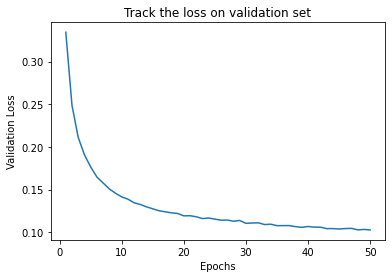

In [24]:
## We track the loss and plot it to see if it converges or if overfitting occurs.
x_epoch = list(range(1, epochs+1))

plt.plot(x_epoch, loss_list)
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title("Track the loss on validation set")
plt.show()

It looks like the model has not converged yet. You could try to increase the number of epochs (usually from 50 to 250) and track the loss again to see if the curve changes.

#### Fine-tune the hyperparameters according to the performance on validation set

In [26]:
y_target = []
y_pred = []

# predict the outcomes on validation set
with torch.no_grad():
    for X, y in valid_dlr:
        pred = model(X)
        y_pred += pred.tolist()  # prediction
        y_target += y.tolist()   # true labels
        

In [29]:
def auroc(l0, p0, l1, p1):
    auc = roc_auc_score(l0, p0)
    ap = average_precision_score(l0, p0)
    auc1 = roc_auc_score(l1, p1)
    ap1 = average_precision_score(l1, p1)

    plt.style.use('seaborn')
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    fpr, tpr, _ = roc_curve(l0, p0)
    precision, recall, _ = precision_recall_curve(l0, p0)
    fpr1, tpr1, _ = roc_curve(l1, p1)
    precision1, recall1, _ = precision_recall_curve(l1, p1)


    ax[0,0].plot(fpr, tpr, label='Diabetes AUC = %.3f' % auc)
    ax[0,0].set_xlim([-.01, 1.01])
    ax[0,0].set_ylim([-.01, 1.01])
    ax[0,0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    ax[0,0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax[0,0].plot([0, 1], [0, 1], 'k--', label='No information')
    ax[0,0].legend(loc='lower right', fontsize=14)

    ax[0,1].plot(recall, precision, label='Diabetes AUC Avg PPV = %.3f' % ap)
    ax[0,1].set_xlim([-.01, 1.01])
    ax[0,1].set_ylim([-.01, 1.01])
    ax[0,1].set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax[0,1].set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax[0,1].plot([0, 1], [l0.mean(), l0.mean()], 'k--', label='No information')
    ax[0,1].legend(loc='upper right', fontsize=14)

    ax[1,0].plot(fpr1, tpr1, label='Outcome 2 AUC = %.3f' % auc1)
    ax[1,0].set_xlim([-.01, 1.01])
    ax[1,0].set_ylim([-.01, 1.01])
    ax[1,0].set_xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    ax[1,0].set_ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    ax[1,0].plot([0, 1], [0, 1], 'k--', label='No information')
    ax[1,0].legend(loc='lower right', fontsize=14)

    ax[1,1].plot(recall1, precision1, label='Outcome 2 Avg PPV  = %.3f' % ap1)
    ax[1,1].set_xlim([-.01, 1.01])
    ax[1,1].set_ylim([-.01, 1.01])
    ax[1,1].set_xlabel('Recall (Sensitivity)', fontsize=14)
    ax[1,1].set_ylabel('Precision (Positive Predictive Value)', fontsize=14)
    ax[1,1].plot([0, 1], [l1.mean(), l1.mean()], 'k--', label='No information')
    ax[1,1].legend(loc='upper right', fontsize=14)
    
    fig.suptitle("Model Performance") 
    plt.tight_layout()
    plt.show()

Now we plot two curves to see the performance on validation set. You could fine-tune the hyperparameters until you find a "best" model with best performance on validation set. Then you will get the final version of model, and you can make prediction on the test set.

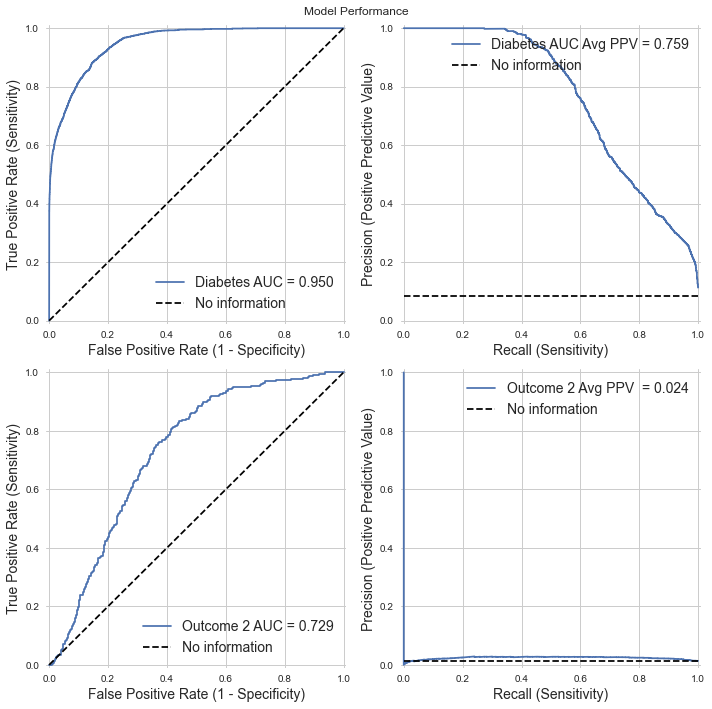

In [30]:
auroc(np.array([y_target[i][0] for i in range(len(y_target))]),
      np.array([y_pred[i][0] for i in range(len(y_pred))]),
      np.array([y_target[i][1] for i in range(len(y_target))]),
      np.array([y_pred[i][1] for i in range(len(y_pred))]))

**Here, we are using AUROC and Precision-recall curves to evaluate the model performance.**

AUROC is a curve that measures the performance of a binary classifier at various thresholds. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different threshold values. The area under this curve (AUROC) provides a measure of the overall performance of the classifier, with higher values indicating better performance.

Precision-recall curve is another evaluation metric that is commonly used in binary classification tasks. It plots the precision (positive predictive value) against the recall (sensitivity) for different threshold values. The area under this curve (AUPRC) provides a measure of the overall performance of the classifier, with higher values indicating better performance.

AUROC is typically used when the class distribution is balanced, while precision-recall curve is more appropriate when the class distribution is imbalanced. Both metrics are useful for evaluating the performance of binary classification models and can provide insights into their strengths and weaknesses.

### Step 5: Evaluate the Model on Test set

Except for AUROC and Precision-Recall curves, we still have some other techniques to assess the discrimination performance. I will summarize the methods that I used in my project in the next tutorial.